# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [3]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [4]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


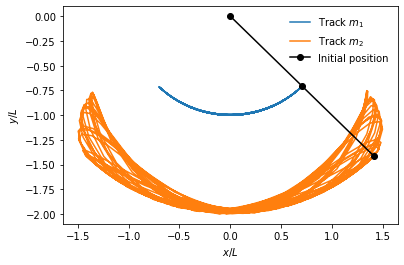

In [5]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



In [6]:
import tensorflow as tf
from tensorflow import keras


In [7]:
coordinateno = 4
windowsize = 10
def createmodel(coordinateno, windowsize):
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(128,input_shape=(coordinateno,windowsize),return_sequences=True)) # LSTM layer with 50 neurons
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(128))
  model.add(keras.layers.Dense(64))
  model.add(keras.layers.Dense(4))
  model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
  return model

In [8]:
model = createmodel(coordinateno, windowsize)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            71168     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 145,348
Trainable params: 145,348
Non-trainable params: 0
_________________________________________________________________


# Generate Data Function

In [9]:
def generate_data(angle1, angle2, tmax, dt, split):
    '''
    Function that generates simulated data using kinematics of double pendulum
    which is then split into two datasets (ie. train and test)

    Input:
    angle1 = start angle for m1
    angle2 = start angle for m2
    tmax = endtime
    dt = timestep
    split = split percentage of dataset into train and test

    Output:
    Train and Test dataset as simulated result
    '''
    
    z0=[angle1,0,angle2,0] #initial values
    
    #The time series goes from 0 to t_0, and the must be predicted from t_0 to t_0+20dt
    t = np.arange(0, tmax + dt, dt)
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax+dt), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    #creating datasets
    data = np.column_stack((x1, y1, x2, y2)).T
    midpointsplit = int(split * len(data[0,:]))
    train_data = data[:,:midpointsplit]
    test_data = data[:,midpointsplit:]
    return train_data, test_data

# Sequencing Function

In [10]:
def shapeArray(data,windowsize,offset):
    '''
    Function that creates sequence of overlapping data for training testing

    Input:
    data = training/testing
    windowsize = size of sequence
    offset = distance between input and output

    Output:
    Two arrays of sequence for model training
    '''
    input, output = [], [] 
    #looping over the dataset
    for i in range(windowsize, len(data[0]) - offset):
        input.append(data[:,(i-windowsize):i]) 
        output.append(data[:,i+offset])
        
    input, output = np.array(input), np.array(output)
    return input, output

## Generating dataset for training and tesing

In [11]:
#using cartesian simulation function to simulate the movements
angle1 = np.pi/4
angle2 = np.pi/4
tmax = 50
dt = 0.01
split = 0.8
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)

offset = 20

#creating inputs and outputs to the LSTM
train_input, train_output = shapeArray(train_data, windowsize, offset)
test_input, test_output = shapeArray(test_data, windowsize, offset)

## Training model
Model was trained using sequence output created above and validated against the test dataset.

In [12]:
history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)

In [13]:
test_loss, test_acc = model.evaluate(test_input, test_output, verbose=1)


31/31 [==============================] - 0s 3ms/step - loss: 6.4548e-04 - accuracy: 0.9949


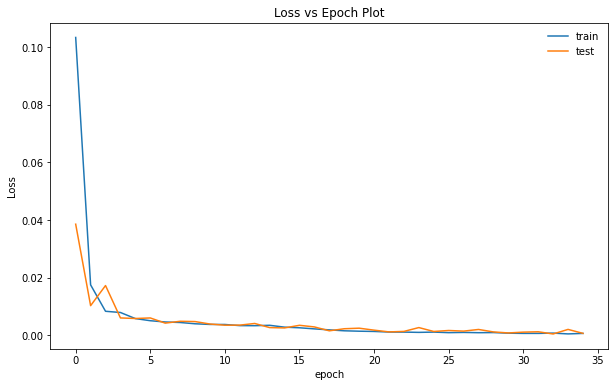

In [14]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss vs Epoch Plot')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plot
The actual movement of double pendulum annd the predicted movement of double pendulum using model is plotted


Text(0.5, 1.0, 'LSTM Predicted Double Pendulum at $\\theta1 = $0.79, $\\theta2 = $0.79 ')

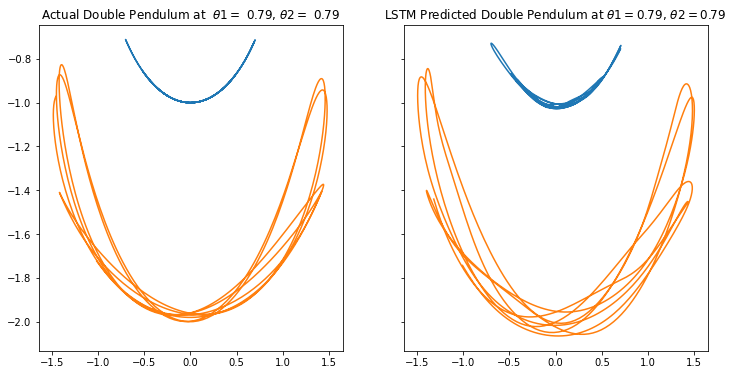

In [15]:
fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
#plotting the first figure (simulated data)
ax[0].plot(test_data[0], test_data[1], label=r"Track $m_1$")
ax[0].plot(test_data[2], test_data[3], label=r"Track $m_2$")
ax[0].set_title(r'Actual Double Pendulum at  $\theta1 = $ %1.2f, $\theta2 = $ %1.2f'%(angle1, angle2), fontsize=12)

model_data = model.predict(test_input)

#plotting the second figure (predicted data)
ax[1].plot(model_data[:,0], model_data[:,1], label=r"Track $m_1$")
ax[1].plot(model_data[:,2], model_data[:,3], label=r"Track $m_2$")
ax[1].set_title(r'LSTM Predicted Double Pendulum at $\theta1 = $%1.2f, $\theta2 = $%1.2f '%(angle1, angle2), fontsize=12)



### Different initial conditions
For different initial condition (value of theta) the both actual and predicted movement is plotted.

A plot of loss against angle value is plotted.

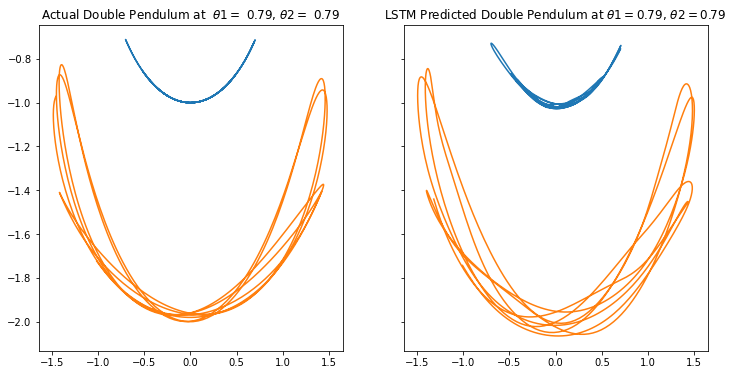

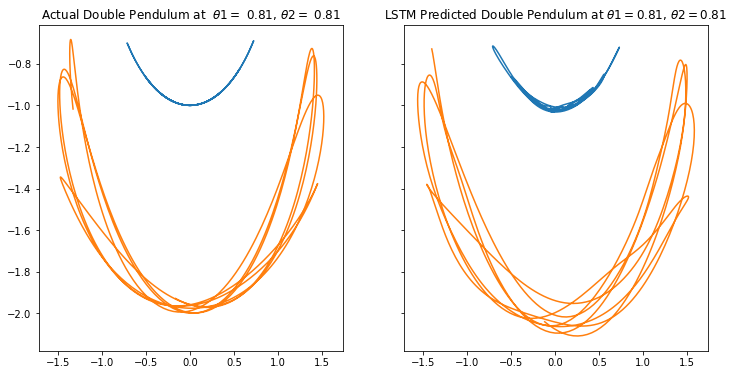

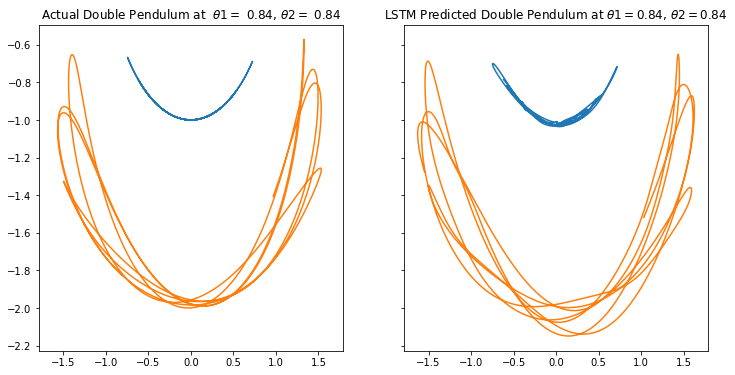

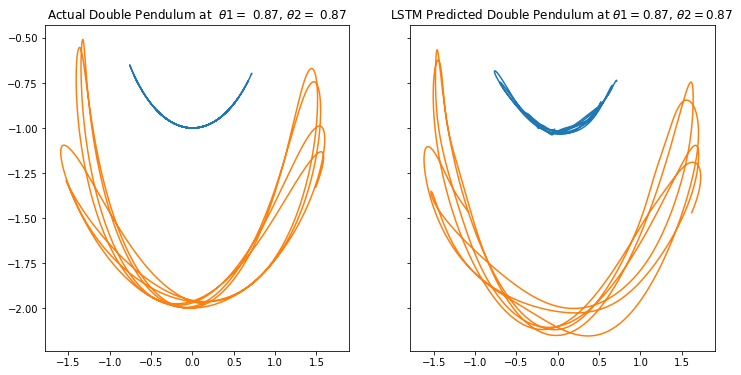

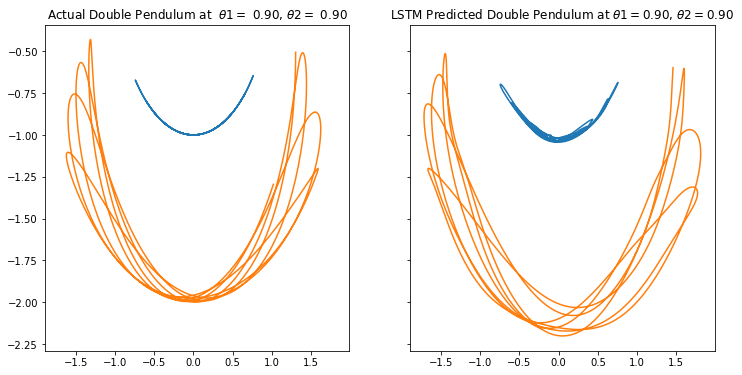

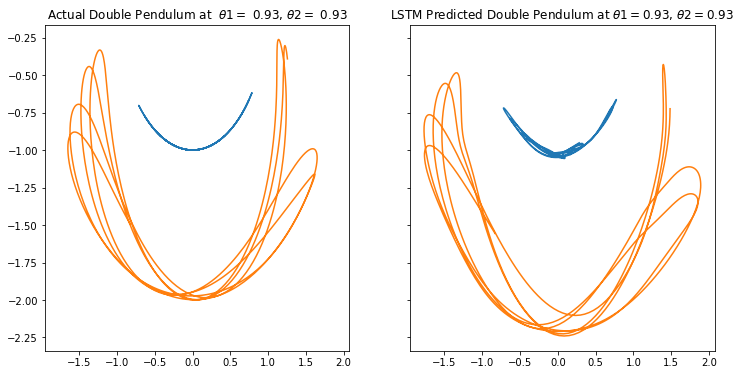

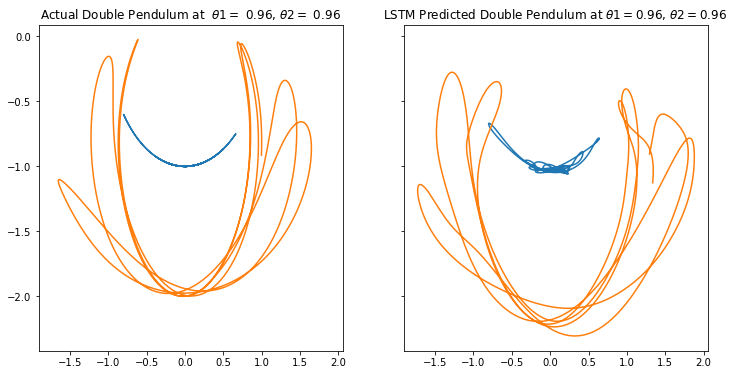

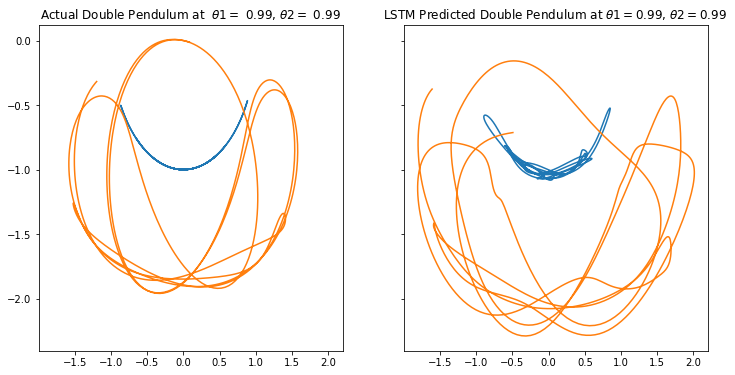

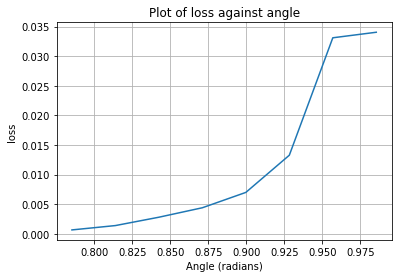

In [16]:
dtheta = np.linspace(0,0.2,8)
loss = []
for i in dtheta:
  angle1 = np.pi/4 + i
  angle2 = np.pi/4 + i
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)

  fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
  #plotting the first figure (simulated data)
  ax[0].plot(test_data[0], test_data[1], label=r"Track $m_1$")
  ax[0].plot(test_data[2], test_data[3], label=r"Track $m_2$")
  ax[0].set_title(r'Actual Double Pendulum at  $\theta1 = $ %1.2f, $\theta2 = $ %1.2f'%(angle1, angle2), fontsize=12)

  test_input, test_output = shapeArray(test_data, windowsize, offset)
  model_data = model.predict(test_input)

  #plotting the second figure (predicted data)
  ax[1].plot(model_data[:,0], model_data[:,1], label=r"Track $m_1$")
  ax[1].plot(model_data[:,2], model_data[:,3], label=r"Track $m_2$")
  ax[1].set_title(r'LSTM Predicted Double Pendulum at $\theta1 = $%1.2f, $\theta2 = $%1.2f '%(angle1, angle2), fontsize=12) 

  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.figure()
plt.title("Plot of loss against angle")
plt.ylabel("loss")
plt.xlabel("Angle (radians)")
theta = np.pi/4+dtheta
plt.plot(theta, loss,'o')
plt.grid()

### Discussion
As seen in the final plot of loss against angle. As the difference in initial condition increase, our loss increase which is expected as our model is not retrained under same condition. But the loss is still relatively small, thus model is still considered a good prediction.

## Different offset
To study how far can our model predict in the future, the model is retrained with different offset (extrapolation time).

In [18]:
model = createmodel(coordinateno, windowsize)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 128)            71168     
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 145,348
Trainable params: 145,348
Non-trainable params: 0
_________________________________________________________________


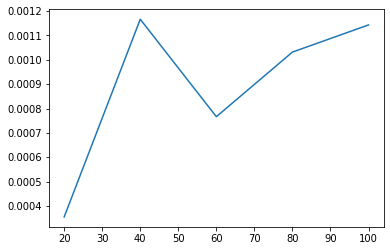

In [19]:
#using cartesian simulation function to simulate the movements
angle1 = np.pi/4
angle2 = np.pi/4
tmax = 50
dt = 0.01
split = 0.8
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
plt.figure()

loss = []
offset = [20, 40, 60, 80, 100]

for i in offset:
  model = createmodel(coordinateno, windowsize)
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
  train_input, train_output = shapeArray(train_data, windowsize, i)
  test_input, test_output = shapeArray(test_data, windowsize, i)
  history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.plot(offset, loss, 'o')
plt.title("Plot of loss against offset")
plt.xlabel("Offset")
plt.ylabel("loss")
plt.grid()


### Discussion
As seen in the final plot the loss increases with increasing offset, indicating that model is getting worse at predicting the further future. But loss value is still relatively small

## $\frac{\pi}{2}$ case

31/31 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9588


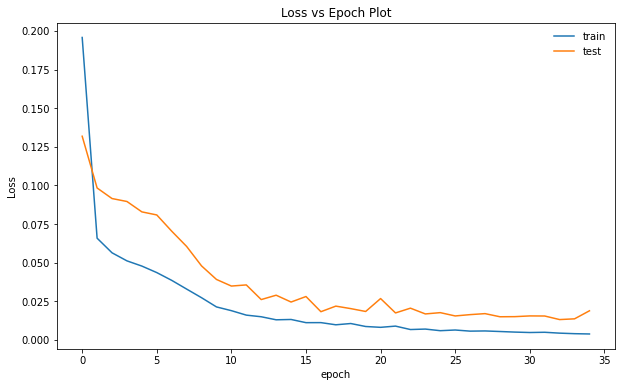

In [20]:
angle1 = np.pi/2
angle2 = np.pi/2
offset = 20
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
train_input, train_output = shapeArray(train_data, windowsize, offset)
test_input, test_output = shapeArray(test_data, windowsize, offset)
model = createmodel(coordinateno, windowsize)
history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
test_loss, test_acc = model.evaluate(test_input, test_output, verbose=1)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss vs Epoch Plot')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

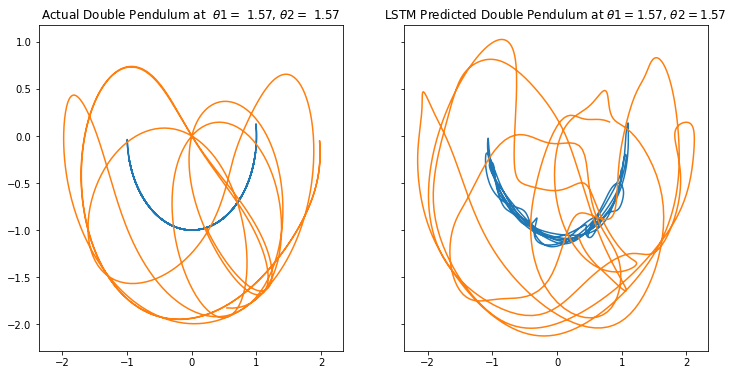

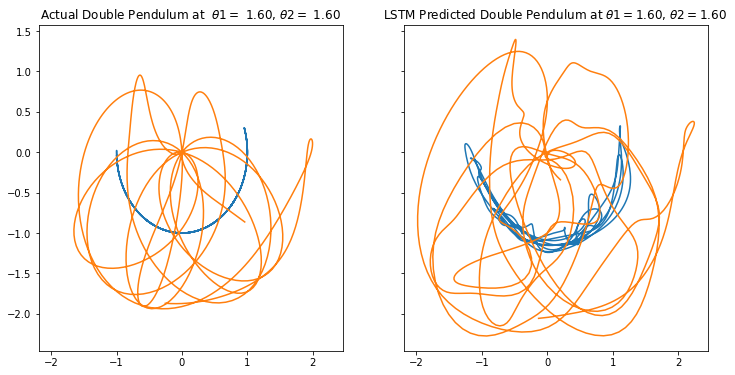

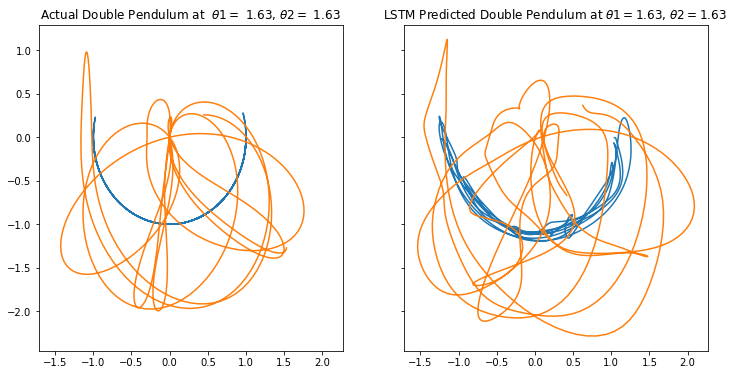

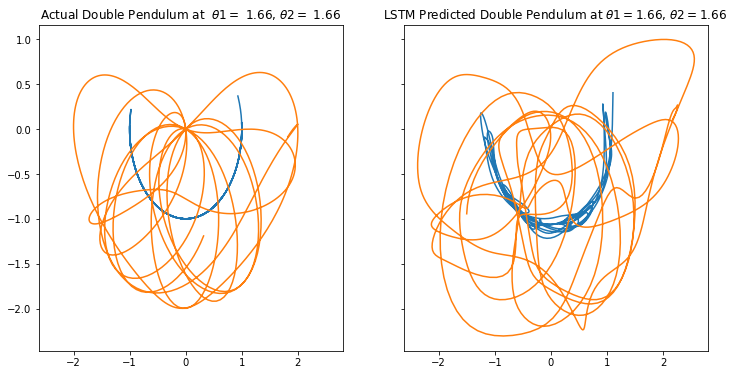

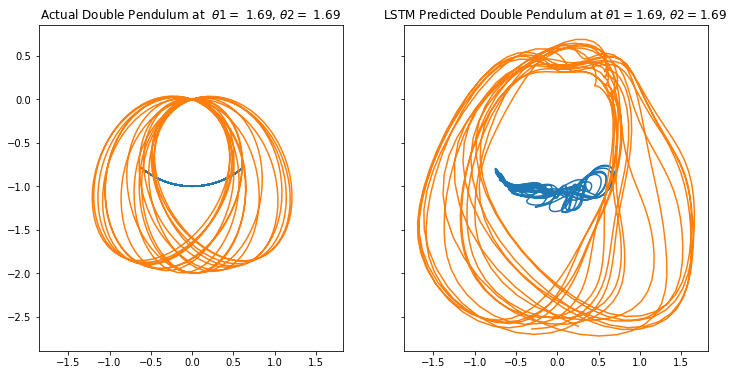

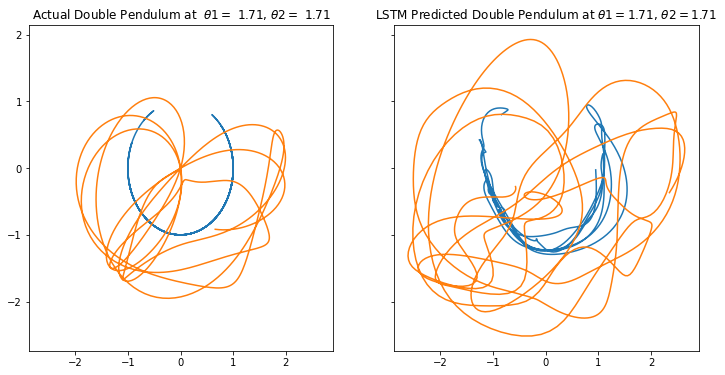

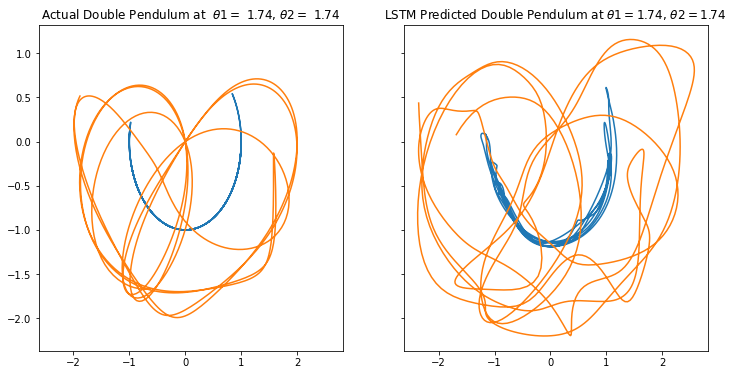

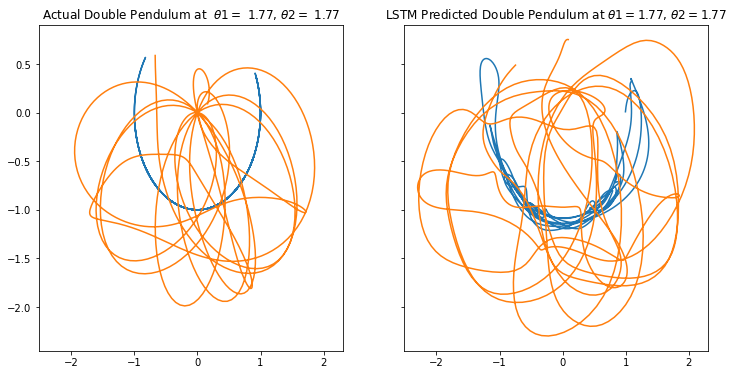

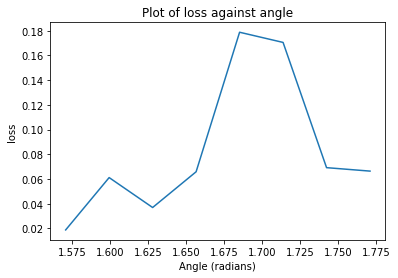

In [22]:
dtheta = np.linspace(0,0.2,8)
loss = []
for i in dtheta:
  angle1 = np.pi/2 + i
  angle2 = np.pi/2 + i
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)

  fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
  #plotting the first figure (simulated data)
  ax[0].plot(test_data[0], test_data[1], label=r"Track $m_1$")
  ax[0].plot(test_data[2], test_data[3], label=r"Track $m_2$")
  ax[0].set_title(r'Actual Double Pendulum at  $\theta1 = $ %1.2f, $\theta2 = $ %1.2f'%(angle1, angle2), fontsize=12)

  test_input, test_output = shapeArray(test_data, windowsize, offset)
  model_data = model.predict(test_input)

  #plotting the second figure (predicted data)
  ax[1].plot(model_data[:,0], model_data[:,1], label=r"Track $m_1$")
  ax[1].plot(model_data[:,2], model_data[:,3], label=r"Track $m_2$")
  ax[1].set_title(r'LSTM Predicted Double Pendulum at $\theta1 = $%1.2f, $\theta2 = $%1.2f '%(angle1, angle2), fontsize=12) 

  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.figure()
plt.title("Plot of loss against angle")
plt.ylabel("loss")
plt.xlabel("Angle (radians)")
theta = np.pi/2+dtheta
plt.plot(theta, loss,'o')
plt.grid()

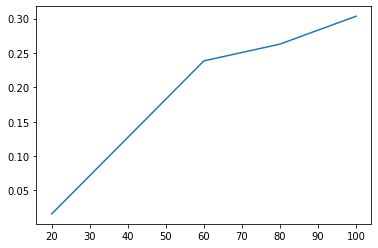

In [23]:
#using cartesian simulation function to simulate the movements
angle1 = np.pi/2
angle2 = np.pi/2
tmax = 50
dt = 0.01
split = 0.8
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
plt.figure()

loss = []
offset = [20, 40, 60, 80, 100]

for i in offset:
  model = createmodel(coordinateno, windowsize)
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
  train_input, train_output = shapeArray(train_data, windowsize, i)
  test_input, test_output = shapeArray(test_data, windowsize, i)
  history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.plot(offset, loss,'o')
plt.grid()

## Discussion
For angle being $\pi/2$ the plot would be more chaotic. Thus the dt is made to be smaller
but the similar relationship still remains

Loss increases as difference in initial condition increases
<br>
Loss increases as offset increases.

# Only m2 given
# $\pi/4$ case
we slice the input dataset so only coordinates of m2 is provided for training of model.

31/31 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.8795


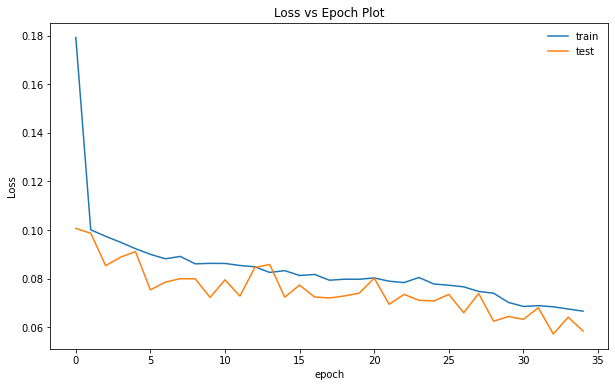

In [33]:
angle1 = np.pi/4
angle2 = np.pi/4
offset = 20
coordinateno = 2
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
train_input, train_output = shapeArray(train_data, windowsize, offset)
test_input, test_output = shapeArray(test_data, windowsize, offset)
train_input = train_input[:,:-2,:]
test_input = test_input[:,:-2,:]
model = createmodel(coordinateno, windowsize)
history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
test_loss, test_acc = model.evaluate(stest_input, test_output, verbose=1)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss vs Epoch Plot')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

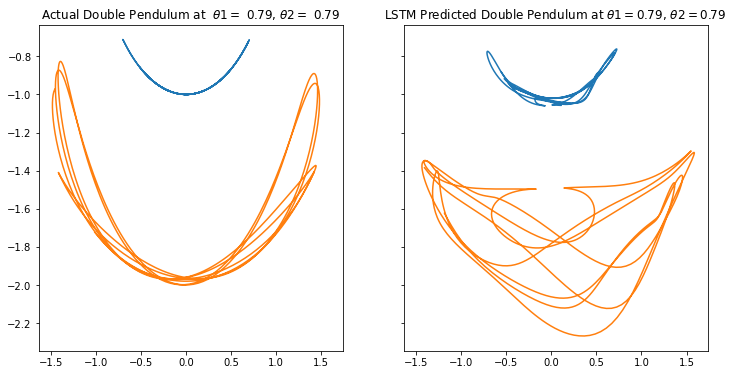

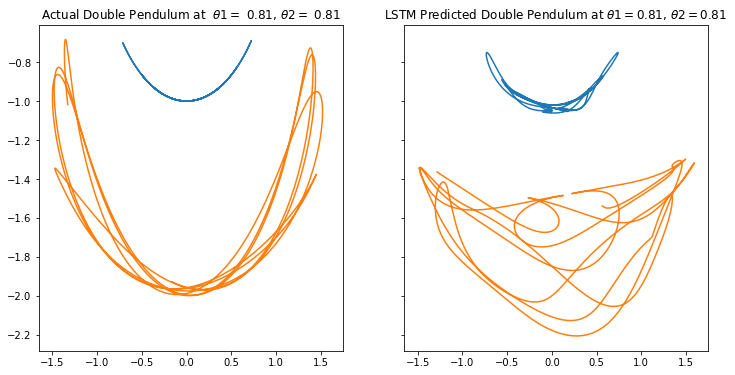

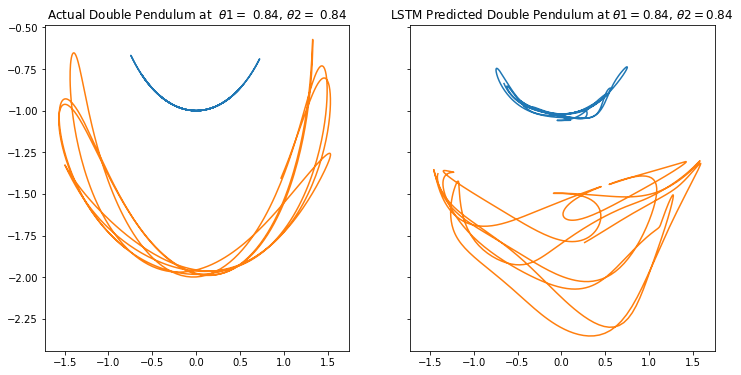

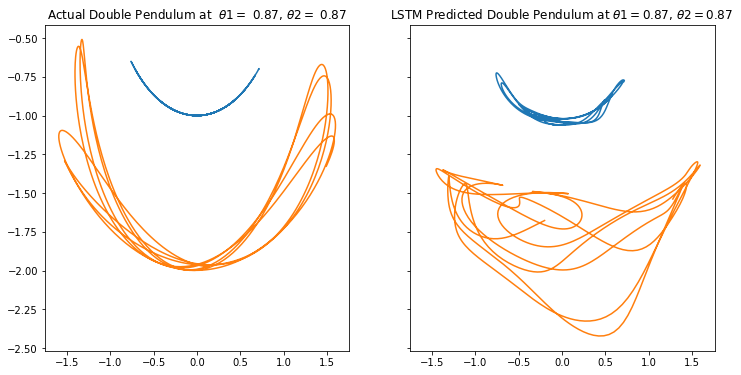

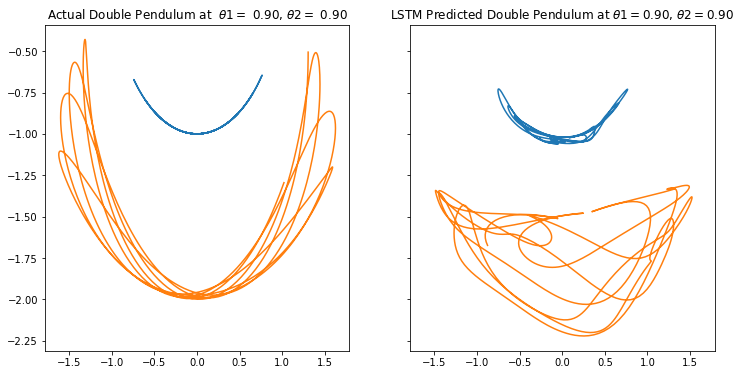

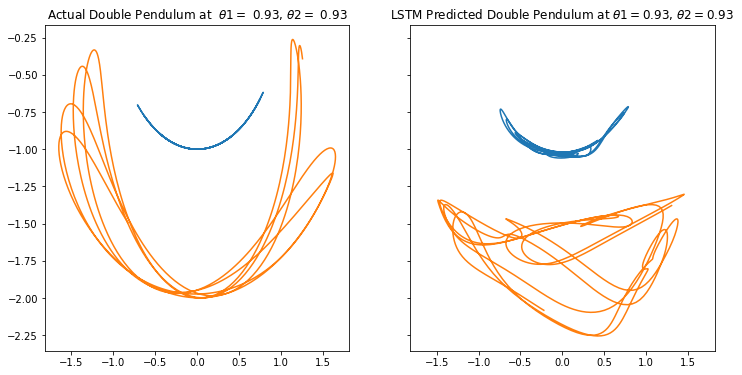

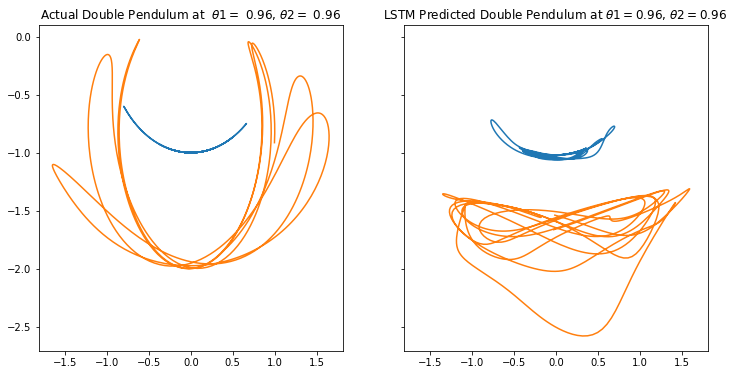

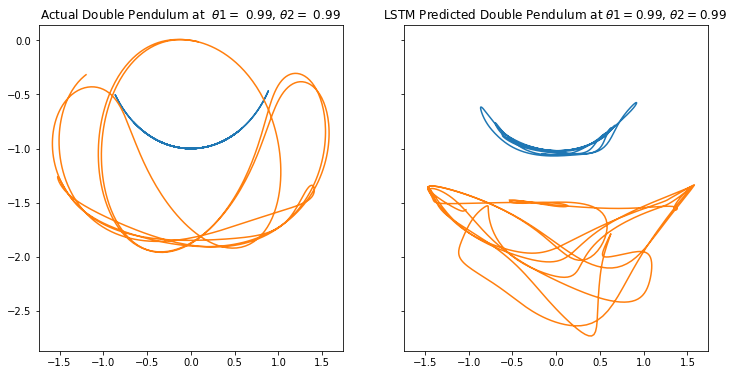

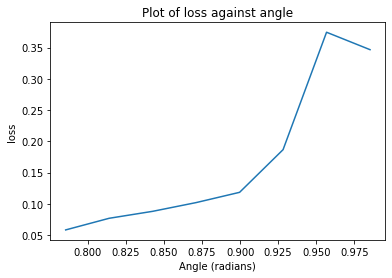

In [35]:
dtheta = np.linspace(0,0.2,8)
loss = []
for i in dtheta:
  angle1 = np.pi/4 + i
  angle2 = np.pi/4 + i
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)

  fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
  #plotting the first figure (simulated data)
  ax[0].plot(test_data[0], test_data[1], label=r"Track $m_1$")
  ax[0].plot(test_data[2], test_data[3], label=r"Track $m_2$")
  ax[0].set_title(r'Actual Double Pendulum at  $\theta1 = $ %1.2f, $\theta2 = $ %1.2f'%(angle1, angle2), fontsize=12)

  test_input, test_output = shapeArray(test_data, windowsize, offset)
  train_input = train_input[:,:-2,:]
  test_input = test_input[:,:-2,:]
  model_data = model.predict(test_input)

  #plotting the second figure (predicted data)
  ax[1].plot(model_data[:,0], model_data[:,1], label=r"Track $m_1$")
  ax[1].plot(model_data[:,2], model_data[:,3], label=r"Track $m_2$")
  ax[1].set_title(r'LSTM Predicted Double Pendulum at $\theta1 = $%1.2f, $\theta2 = $%1.2f '%(angle1, angle2), fontsize=12) 

  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.figure()
plt.title("Plot of loss against angle")
plt.ylabel("loss")
plt.xlabel("Angle (radians)")
theta = np.pi/4+dtheta
plt.plot(theta, loss,'o')
plt.grid()

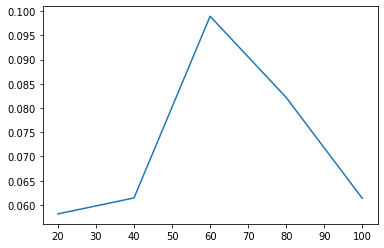

In [36]:
#using cartesian simulation function to simulate the movements
angle1 = np.pi/4
angle2 = np.pi/4
tmax = 50
dt = 0.01
split = 0.8
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
plt.figure()

loss = []
offset = [20, 40, 60, 80, 100]

for i in offset:
  model = createmodel(coordinateno, windowsize)
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
  train_input, train_output = shapeArray(train_data, windowsize, i)
  test_input, test_output = shapeArray(test_data, windowsize, i)
  train_input = train_input[:,:-2,:]
  test_input = test_input[:,:-2,:]

  history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.plot(offset, loss,'o')
plt.grid()

## $\pi/2$ case

31/31 [==============================] - 0s 2ms/step - loss: 0.3023 - accuracy: 0.5057


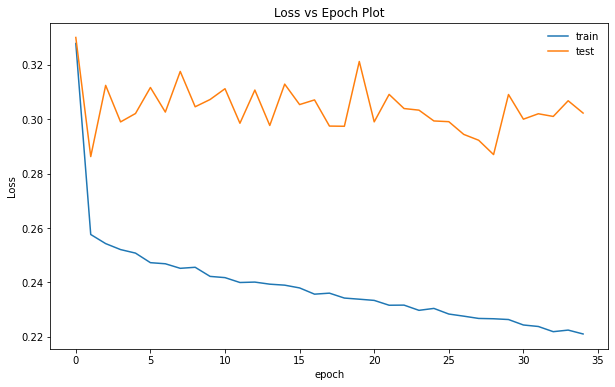

In [40]:
angle1 = np.pi/2
angle2 = np.pi/2
offset = 20
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
train_input, train_output = shapeArray(train_data, windowsize, offset)
test_input, test_output = shapeArray(test_data, windowsize, offset)
train_input = train_input[:,:-2,:]
test_input = test_input[:,:-2,:]
model = createmodel(coordinateno, windowsize)
history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
test_loss, test_acc = model.evaluate(test_input, test_output, verbose=1)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss vs Epoch Plot')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

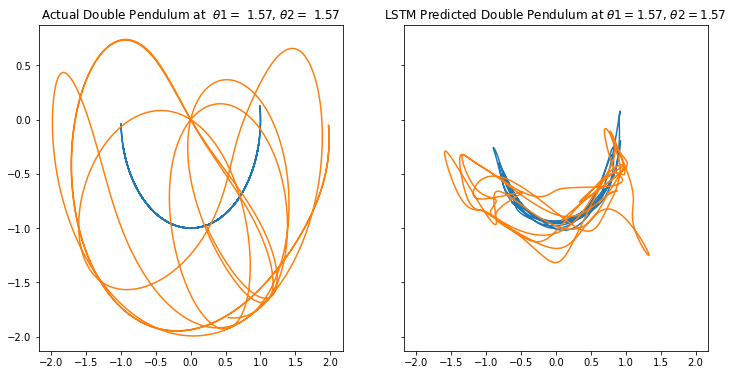

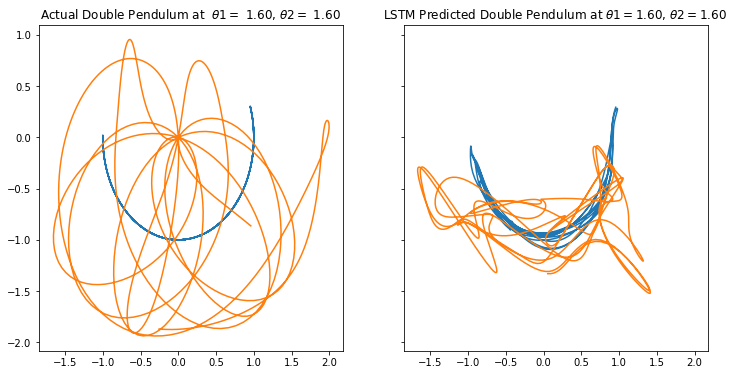

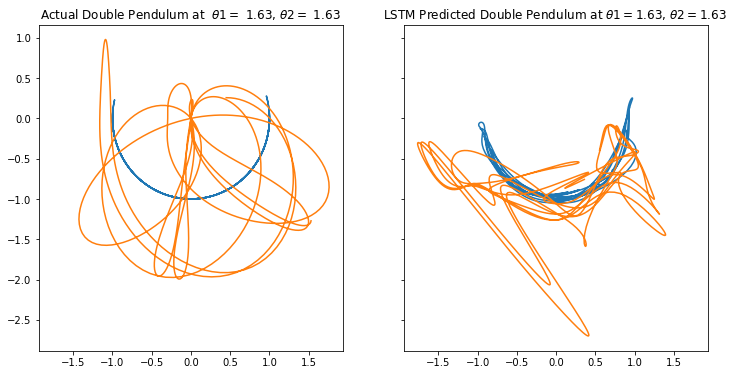

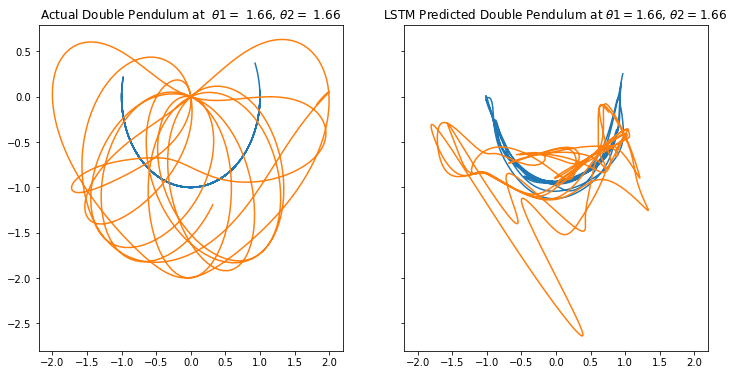

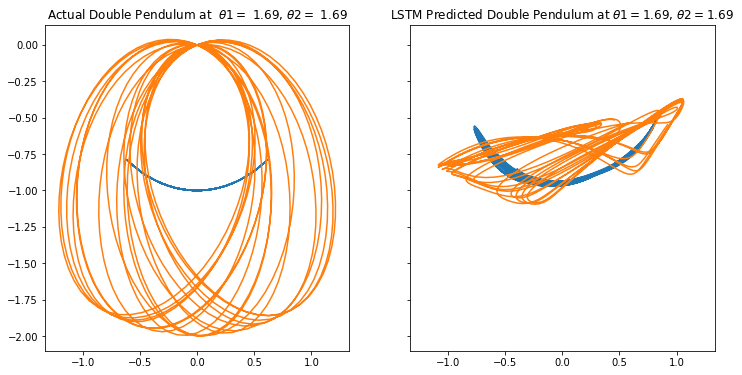

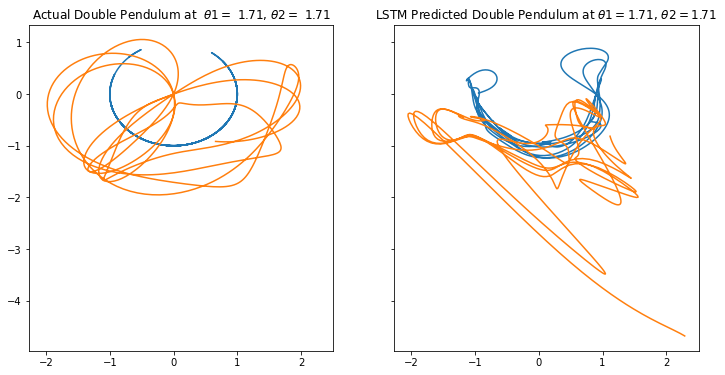

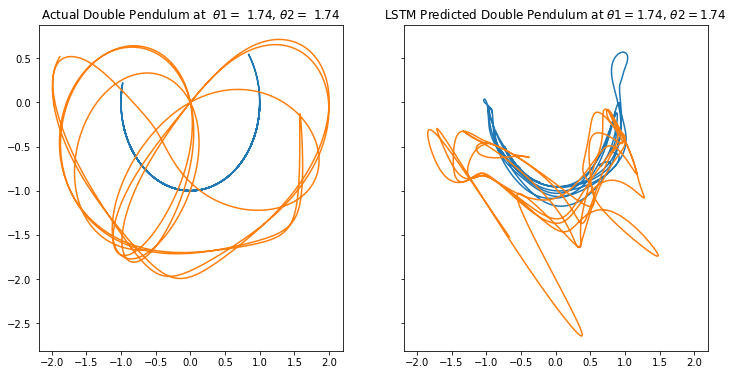

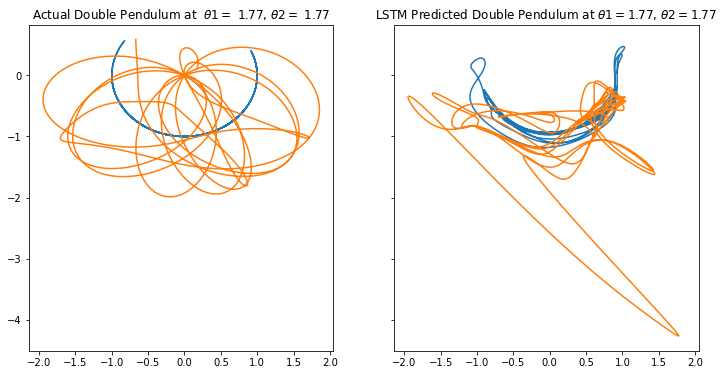

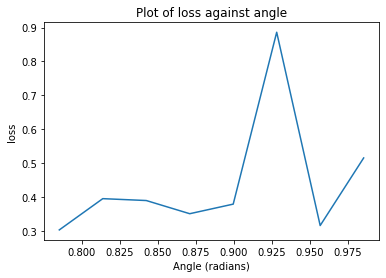

In [41]:
dtheta = np.linspace(0,0.2,8)
loss = []
for i in dtheta:
  angle1 = np.pi/2 + i
  angle2 = np.pi/2 + i
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)

  fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
  #plotting the first figure (simulated data)
  ax[0].plot(test_data[0], test_data[1], label=r"Track $m_1$")
  ax[0].plot(test_data[2], test_data[3], label=r"Track $m_2$")
  ax[0].set_title(r'Actual Double Pendulum at  $\theta1 = $ %1.2f, $\theta2 = $ %1.2f'%(angle1, angle2), fontsize=12)

  test_input, test_output = shapeArray(test_data, windowsize, offset)
  train_input = train_input[:,:-2,:]
  test_input = test_input[:,:-2,:]
  model_data = model.predict(test_input)

  #plotting the second figure (predicted data)
  ax[1].plot(model_data[:,0], model_data[:,1], label=r"Track $m_1$")
  ax[1].plot(model_data[:,2], model_data[:,3], label=r"Track $m_2$")
  ax[1].set_title(r'LSTM Predicted Double Pendulum at $\theta1 = $%1.2f, $\theta2 = $%1.2f '%(angle1, angle2), fontsize=12) 

  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.figure()
plt.title("Plot of loss against angle")
plt.ylabel("loss")
plt.xlabel("Angle (radians)")
theta = np.pi/4+dtheta
plt.plot(theta, loss,'o')
plt.grid()

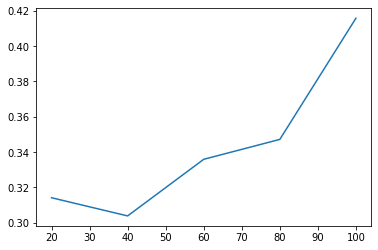

In [42]:
#using cartesian simulation function to simulate the movements
angle1 = np.pi/2
angle2 = np.pi/2
tmax = 50
dt = 0.01
split = 0.8
train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
plt.figure()

loss = []
offset = [20, 40, 60, 80, 100]

for i in offset:
  model = createmodel(coordinateno, windowsize)
  train_data, test_data = generate_data(angle1, angle2, tmax, dt, split)
  train_input, train_output = shapeArray(train_data, windowsize, i)
  test_input, test_output = shapeArray(test_data, windowsize, i)
  train_input = train_input[:,:-2,:]
  test_input = test_input[:,:-2,:]

  history = model.fit(train_input, train_output, epochs=35, batch_size=32, validation_data=(test_input, test_output), verbose=0)
  test_loss, test_acc = model.evaluate(test_input, test_output, verbose=0)
  loss.append(test_loss)

plt.plot(offset, loss,'o')
plt.grid()

# Discussion
With lesser information given (position and angle of m2) we expect model to be less accurate at predicting. Thus giving a higher loss value.